### Problem Statement
Stock price prediction is the task of forecasting the future value of a given stock. Given the historical daily 
close price for S&P 500 Index, prepare and compare forecasting solutions.

S&P 500 or Standard and Poor's 500 index is an index comprising of 500 stocks from different sectors of 
US economy and is an indicator of US equities. Other such indices are the Dow 30, NIFTY 50, Nikkei 225, etc. 

In [1]:
%matplotlib inline

import math
import warnings
import numpy as np

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

import keras
from sklearn.metrics import mean_squared_error

import time
import pandas as pd
import pandas_datareader as pdr

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler



import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
sns.set_context('notebook')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

### Define Functions

In [1]:
# get stock price information 
def get_raw_data(index_name,retry_attempts = 3):   
    if index_name:
        while retry_attempts > 0 :
            try:
                df = pdr.get_data_yahoo(index_name)
                new_df = df.reindex(index=pd.date_range(df.index.min(), 
                                          df.index.max(), 
                                          freq='D')).fillna(method='ffill')
                retry_attempts = 0
                return new_df
            except:
                print("Data pull failed. {} retry attempts remaining".\
                      format(retry_attempts))
                retry_attempts = retry_attempts - 1
    else:
        print("Invalid usage. Parameter index_name is required")
    return None
    

# prepare training and testing data sets for LSTM based regression modeling
def get_reg_train_test(timeseries,sequence_length= 51,
                   train_size=0.9,roll_mean_window=5,
                   normalize=True,scale=False):
    # smoothen out series
    if roll_mean_window:
        timeseries = timeseries.rolling(roll_mean_window).mean().dropna()
    
    # create windows
    result = []
    for index in range(len(timeseries) - sequence_length):
        result.append(timeseries[index: index + sequence_length])
           
    
    # normalize data as a variation of 0th index
    if normalize:
        normalised_data = []
        for window in result:
            normalised_window = [((float(p) / float(window[0])) - 1) \
                                   for p in window]
            normalised_data.append(normalised_window)
        result = normalised_data
    
    # identify train-test splits
    result = np.array(result) 
    row = round(train_size * result.shape[0])
    
    # split train and test sets
    train = result[:int(row), :]
    test = result[int(row):, :]
    
    # scale data in 0-1 range
    scaler = None
    if scale:
        scaler=MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
      
    # split independent and dependent variables  
    x_train = train[:, :-1]
    y_train = train[:, -1]
        
        
    x_test = test[:, :-1]
    y_test = test[:, -1]
    
    # Transforms for LSTM input
    x_train = np.reshape(x_train, (x_train.shape[0], 
                                   x_train.shape[1], 
                                   1))
    x_test = np.reshape(x_test, (x_test.shape[0], 
                                 x_test.shape[1], 
                                 1)) 
    
    return x_train,y_train,x_test,y_test,scaler   



# Get stacked LSTM model for regression modeling
def get_reg_model(layer_units=[100,100],dropouts=[0.2,0.2],window_size=50):
    # build LSTM network
    model = Sequential()
    
    # hidden layer 1
    model.add(LSTM(layer_units[0], 
                   input_shape=(window_size,1), 
                   return_sequences=True))
    model.add(Dropout(dropouts[0]))
    
    # hidden layer 2
    model.add(LSTM(layer_units[1]))
    model.add(Dropout(dropouts[1]))
    
    # output layer
    model.add(Dense(1))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    print(model.summary())
    return model





# Window wise prediction function
def predict_reg_multiple(model, data, window_size=6, prediction_len=3):
    prediction_list = []
    
    # loop for every sequence in the dataset
    for window in range(int(len(data)/prediction_len)):
        _seq = data[window*prediction_len]
        predicted = []
        # loop till required prediction length is achieved
        for j in range(prediction_len):
            predicted.append(model.predict(_seq[np.newaxis,:,:])[0,0])
            _seq = _seq[1:]
            _seq = np.insert(_seq, [window_size-1], predicted[-1], axis=0)
        prediction_list.append(predicted)
    return prediction_list


# Plot window wise 
def plot_reg_results(predicted_data, true_data, prediction_len=3):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    
    # plot actual data
    ax.plot(true_data, 
            label='True Data',
            c='black',alpha=0.3)
    
    # plot flattened data
    plt.plot(np.array(predicted_data).flatten(), 
             label='Prediction_full',
             c='g',linestyle='--')
    
    #plot each window in the prediction list
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction',c='black')

    plt.title("Forecast Plot with Prediction Window={}".format(prediction_len))
    plt.show()
    

## Set Parameters

In [4]:
WINDOW = 6
PRED_LENGTH = int(WINDOW/2)
STOCK_INDEX = '^GSPC'

## Getting Data

<AxesSubplot:>

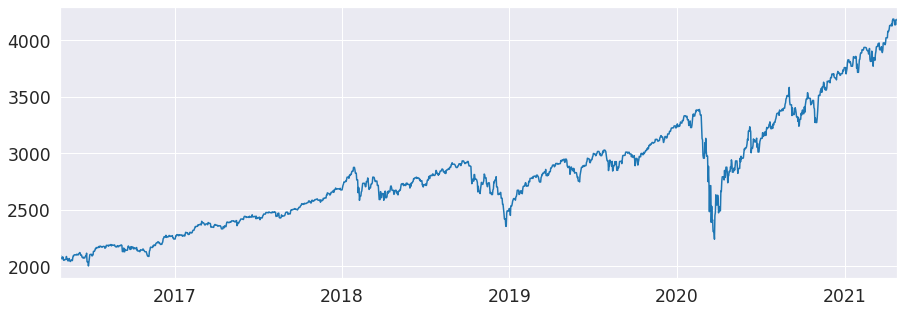

In [5]:
sp_df = get_raw_data(STOCK_INDEX)
sp_close_series = sp_df.Close 

sp_close_series.plot()

## Preprocessing Data

For using LSTMs to model our time series, we need to apply one more level of transformation 
to be able to input our data. LSTMs accept 3D tensors as input, we transform each of the windows 
(or sequences) in (N, W, F) format. Here, N is the number of samples or windows from the original time 
series, W is the size of each window or the number of historical time steps and F is the number of features 
per time step. 
In our case, as we are only using the closing price, F is equal to 1, N and W are configurable.

The function get_reg_train_test() not only transforms for LSTM input, but also performs a number of other optional preprocessing steps. It allows us to smoothen the time series using rolling mean before the windowing is applied. 
We can also normalize the data as well as scale based on requirements. Neural networks are sensitive to input values 
and it is generally advised to scale inputs before training the network. For this use case, we will utilize the 
normalization of the time series wherein, for each window, every time step is the percentage change from 
the first value in that window (we could also use scaling or both and repeat the process).

In [6]:
x_train,y_train,x_test,y_test,scaler = get_reg_train_test(sp_close_series,
                                                      sequence_length=WINDOW+1,
                                                      roll_mean_window=None,
                                                      normalize=True,
                                                      scale=False)
    
print("Data Split Complete")

print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

Data Split Complete
x_train shape=(1637, 6, 1)
y_train shape=(1637,)
x_test shape=(182, 6, 1)
y_test shape=(182,)



The x_train and x_test tensors conform to the (N, W, F) format and is required 
for input to our RNN. We have 1637 sequences in our training set, each with six time steps and one value to 
forecast. Similarly, we have 182 sequences in our test set.

Now that we have our datasets preprocessed and ready, we build up an RNN network using keras. The 
keras framework provides us high level abstractions to work with neural networks over theano and tensorflow
backends using the get_reg_model() function.


## Prepare LSTM Model

The generated LSTM model architecture has two hidden LSTM layers stacked over each other with 
first one having 50 LSTM units and the second one having 100. The output layer is a Dense layer with linear 
activation function. We use mean squared error as our loss function to optimize upon. Since we are stacking 
LSTM layers, we need to set return_sequences to true in order for the subsequent layer to get the required 
values. As is evident, keras abstracts most of the heavy lifting and makes it pretty intuitive to build even 
complex architectures with just a few lines of code.

In [7]:
lstm_model=None
try:
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)   
except:
    print("Model Build Failed. Trying Again")
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)

> Compilation Time :  0.00479435920715332
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 6, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
__________

## Fit the Model

The model generates information regarding training and validation loss for every epoch it runs. The callback 
for stopping enables us to stop the training if there is no further improvement observed for two consecutive 
epochs. We start with a batch size of 16, 20 epochs and a validation set of 5%.

In [8]:
# use eatrly stopping to avoid overfitting     
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=2,
                                           verbose=0)]
lstm_model.fit(x_train, y_train, 
               epochs=20, batch_size=16,
               verbose=1,validation_split=0.05,
               callbacks=callbacks)
print("Model Fit Complete")

Epoch 1/20
98/98 [==============================] - 4s 20ms/step - loss: 4.7321e-04 - val_loss: 6.3194e-04
Epoch 2/20
98/98 [==============================] - 1s 11ms/step - loss: 2.5686e-04 - val_loss: 9.9730e-05
Epoch 3/20
98/98 [==============================] - 1s 10ms/step - loss: 1.6497e-04 - val_loss: 1.1077e-04
Epoch 4/20
98/98 [==============================] - 1s 10ms/step - loss: 1.5866e-04 - val_loss: 2.3224e-04
Model Fit Complete


## Train Prediction Performance

Since we have modeled this as a regression problem with a fixed window size, we would generate forecasts for every sequence. To do so, we defined function called predict_reg_multiple().

1. For every sequence in the list of windowed sequences, repeat Steps below:
* Use keras’s predict() function to generate one output value.
* Append this output value to the end of the input sequence and remove the 
first value to maintain the window size.
* Then repeat this process until the required prediction length 
is achieved.
2. The function utilizes predicted values to forecast subsequent ones.

In [9]:
train_pred_seqs = predict_reg_multiple(lstm_model,
                                             x_train,
                                             window_size=WINDOW,
                                             prediction_len=PRED_LENGTH)

train_offset = y_train.shape[0] - np.array(train_pred_seqs).flatten().shape[0]

train_rmse = math.sqrt(mean_squared_error(y_train[train_offset:], 
                                          np.array(train_pred_seqs).\
                                          flatten()))
print('Train Score: %.2f RMSE' % (train_rmse))

Train Score: 0.03 RMSE


## Test Prediction Performance

In [10]:
test_pred_seqs = predict_reg_multiple(lstm_model,
                                      x_test,
                                      window_size=WINDOW,
                                      prediction_len=PRED_LENGTH)
test_offset = y_test.shape[0] - np.array(test_pred_seqs).flatten().shape[0]

test_rmse = math.sqrt(mean_squared_error(y_test[test_offset:], 
                                          np.array(test_pred_seqs).\
                                          flatten()))
print('Test Score: %.2f RMSE' % (test_rmse))

Test Score: 0.03 RMSE


## Plot Test Predictions

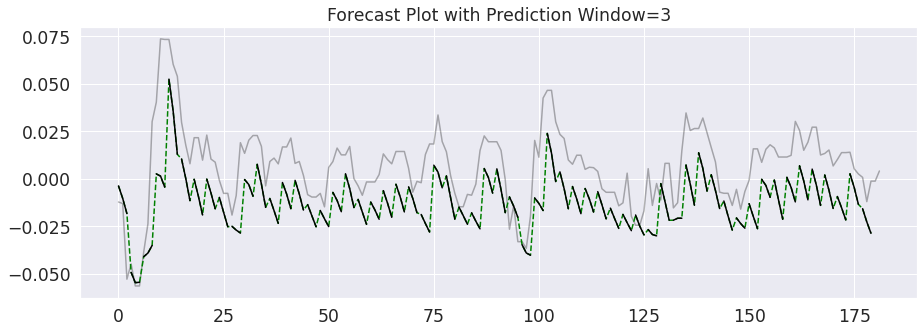

In [11]:
plot_reg_results(test_pred_seqs,y_test,prediction_len=PRED_LENGTH)

the gray line is the original/true test data (normalized) and the black lines denote the 
predicted/forecast values in three-day periods. The dotted line is used to explain the overall flow of the 
predicted series. As is evident, the forecasts are off the mark to some extent from the actual data trends yet 
they seem to have some similarity to the actual data.